# Stereoisomer testing on ChiENN - Cis/Trans

## Importing section

In [1]:
import sys

import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

sys.path.append("../../../../")
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.transform import edge_graph_transform

## Define SMILES strings

In [2]:
smiles_list = [
    "CC=CC",
    "C/C=C/C",
    "C\C=C\C",
    "C/C=C\C",
    "C\C=C/C",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

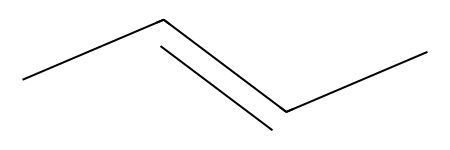

[]
Bond 1 stereo: STEREONONE


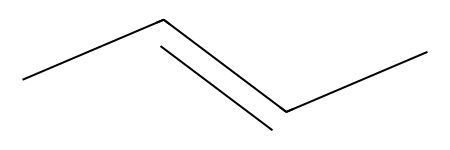

[]
Bond 1 stereo: STEREOE


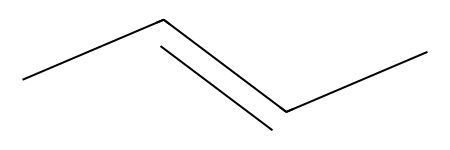

[]
Bond 1 stereo: STEREOE


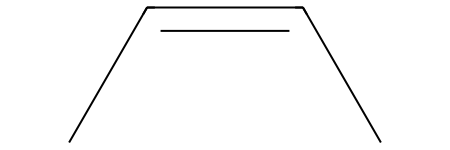

[]
Bond 1 stereo: STEREOZ


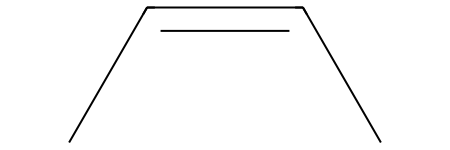

[]
Bond 1 stereo: STEREOZ


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'cis_trans_edges': True
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[22, 93], edge_index=[2, 58], edge_attr=[58, 57], pos=[22, 6], parallel_node_index=[22], circle_index=[22], ptree=[22], initial_map=[80], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1, {"Z": [3, 5, 7]}]}', '{"S": [1, 0, {"Z": [9, 11]}]}', '{"S": [2, 3, {"Z": [1, 7, 5]}]}', '{"S": [3, 2]}', '{"S": [4, 5, {"Z": [1, 3, 7]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"Z": [1, 5, 3]}]}', '{"S": [7, 6]}', '{"S": [8, 9, {"Z": [0, 11]}]}', '{"S": [9, 8, {"Z": [13, 15]}]}', '{"S": [10, 11, {"Z": [0, 9]}]}', '{"S": [11, 10]}', '{"S": [12, 13, {"Z": [8, 15]}]}', '{"S": [13, 12, {"Z": [17, 21, 19]}]}', '{"S": [14, 15, {"Z": [8, 13]}]}', '{"S": [15, 14]}', '{"S": [16, 17, {"Z": [12, 19, 21]}]}', '{"S": [17, 16]}', '{"S": [18, 19, {"Z": [12, 21, 17]}]}', '{"S": [19, 18]}', '{"S": [20, 21, {"Z": [12, 17, 19]}]}', '{"S": [21, 20]}']
Data(x=[22, 93], edge_index=[2, 58], edge_attr=[58, 57], 

## Create Model

In [9]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3
model = AdvancedPermutationTreeLayer(
    hidden_dim=93,
    k=k,
    batch_norm=False
)
model

AdvancedPermutationTreeLayer(
  (p_layer): Linear(in_features=93, out_features=93, bias=False)
  (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (p_elu): ELU(alpha=1.0)
  (z_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (s_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (z2_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (z2_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (s2_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (s2_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (elu): ELU(alpha=1.0)
  (batch_norm): BatchNorm1d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Create batches

In [10]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [11]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all()
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Put batches through model

In [12]:
from torch.nn import BatchNorm1d, Linear

n = BatchNorm1d(93)

for i, batch in enumerate(batch_list):
    # batch.x *= 100
    # batch.x = batch.x + out_list[i]
    # batch.x = l(batch.x)
    batch.x = n(batch.x)

In [13]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [14]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True]])

In [15]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True]])

In [16]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.       , 16.289589 , 16.289589 , 15.988904 , 15.988904 ],
       [16.289589 ,  0.       ,  0.       ,  1.1034179,  1.1034179],
       [16.289589 ,  0.       ,  0.       ,  1.1034179,  1.1034179],
       [15.988904 ,  1.1034179,  1.1034179,  0.       ,  0.       ],
       [15.988904 ,  1.1034179,  1.1034179,  0.       ,  0.       ]],
      dtype=float32)

Can distinguish cis/trans (E/Z)

# Batched version

In [17]:
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3
model = AdvancedPermutationTreeLayer(
    hidden_dim=93,
    k=k,
    batch_norm=False
)
model

AdvancedPermutationTreeLayer(
  (p_layer): Linear(in_features=93, out_features=93, bias=False)
  (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (p_elu): ELU(alpha=1.0)
  (z_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (s_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (z2_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (z2_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (s2_layer): ModuleList(
    (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
  )
  (s2_final_layer): Linear(in_features=93, out_features=93, bias=False)
  (elu): ELU(alpha=1.0)
  (batch_norm): BatchNorm1d(93, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Create batches

In [18]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [19]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all()
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Put batches through model

In [20]:
from torch.nn import BatchNorm1d, Linear

n = BatchNorm1d(93)

for i, batch in enumerate(batch_list):
    # batch.x *= 1000
    # batch.x = batch.x + out_list[i]
    # batch.x = l(batch.x)
    batch.x = n(batch.x)

In [21]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [22]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True]])

In [23]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True]])

In [24]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.       , 17.009295 , 17.009295 , 17.497042 , 17.497042 ],
       [17.009295 ,  0.       ,  0.       ,  1.5112934,  1.5112934],
       [17.009295 ,  0.       ,  0.       ,  1.5112934,  1.5112934],
       [17.497042 ,  1.5112934,  1.5112934,  0.       ,  0.       ],
       [17.497042 ,  1.5112934,  1.5112934,  0.       ,  0.       ]],
      dtype=float32)

Can distinguish cis/trans (E/Z)

# Multiple stacked layers

In [25]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=False,
    ))
    for _ in range(1)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=False,
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z2_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s2_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (elu): ELU(alpha=1.0)
      (

## Create batches

In [26]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [27]:
for idx, batch in enumerate(batch_list):
    display(f"Batch: {idx}")
    display(batch.ptree)
    display(batch.initial_map)
    for layer_idx in range(batch.num_layer):
        display(f"Layer: {layer_idx}")
        display(
            batch[f"layer{layer_idx}_order_matrix"],
            batch[f"layer{layer_idx}_type_mask"],
            batch[f"layer{layer_idx}_pooling"]
        )

'Batch: 0'

['{"S": [0, 1, {"Z": [3, 5, 7]}]}',
 '{"S": [1, 0, {"Z": [9, 11]}]}',
 '{"S": [2, 3, {"Z": [1, 7, 5]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [1, 3, 7]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [1, 5, 3]}]}',
 '{"S": [7, 6]}',
 '{"S": [8, 9, {"Z": [0, 11]}]}',
 '{"S": [9, 8, {"Z": [13, 15]}]}',
 '{"S": [10, 11, {"Z": [0, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"Z": [8, 15]}]}',
 '{"S": [13, 12, {"Z": [17, 21, 19]}]}',
 '{"S": [14, 15, {"Z": [8, 13]}]}',
 '{"S": [15, 14]}',
 '{"S": [16, 17, {"Z": [12, 19, 21]}]}',
 '{"S": [17, 16]}',
 '{"S": [18, 19, {"Z": [12, 21, 17]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"Z": [12, 17, 19]}]}',
 '{"S": [21, 20]}']

tensor([ 0,  1,  3,  5,  7,  1,  0,  9, 11,  2,  3,  1,  7,  5,  3,  2,  4,  5,
         1,  3,  7,  5,  4,  6,  7,  1,  5,  3,  7,  6,  8,  9,  0, 11,  9,  8,
        13, 15, 10, 11,  0,  9, 11, 10, 12, 13,  8, 15, 13, 12, 17, 21, 19, 14,
        15,  8, 13, 15, 14, 16, 17, 12, 19, 21, 17, 16, 18, 19, 12, 21, 17, 19,
        18, 20, 21, 12, 17, 19, 21, 20])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79],
        [-1, -1,  3,  4,  2, -1, -1,  8,  7, -1, -1, 12, 13, 11, -1, -1, -1, -1,
         19, 20, 18, -1, -1, -1, -1, 26, 27, 25, -1, -1, -1, -1, 33, 32, -1, -1,
         37, 36, -1, -1, 41, 40, -1, -1, -1, -1, 47, 46, -1, -1, 51, 52, 50, -1,
         -1, 56, 55, -1, -1, -1, -1, 62, 63, 61, -1, -1, -1, -1, 69, 70, 68, -1,
         -1, -1, -1, 76, 77, 75, -1, -1],
        [-1, -1,  4,  2,  3, -1, -1, -1, -1, -1, -1, 13, 11, 12, -1, -1, -1, -1,
         20, 18, 19, -1, -1, -1, -1, 27, 25, 26, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, 50, 51, -1,
         -1, -1, -1, -1, 

tensor([0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 0, 0])

tensor([ 0,  1,  2,  2,  2,  3,  4,  5,  5,  6,  7,  8,  8,  8,  9, 10, 11, 12,
        13, 13, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 23, 24, 25,
        26, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 37, 38,
        39, 40, 40, 41, 42, 43, 44, 45, 45, 45, 46, 47, 48, 49, 50, 50, 50, 51,
        52, 53, 54, 55, 55, 55, 56, 57])

'Layer: 1'

tensor([[ 0, -1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, 21, -1, -1, 24, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35,
         -1, -1, 38, -1, -1, 41, -1, 43, -1, -1, 46, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1],
        [ 1, -1, -1,  4, -1, -1,  7, -1, -1, 10, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, 22, -1, -1, 25, -1, -1, 28, -1, -1, 31, -1, 33, -1, -1, 36,
         -1, -1, 39, -1, -1, 42, -1, 44, -1, -1, 47, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1],
        [ 2, -1, -1,  5, -1, -1,  8, -1, -1, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, -1, -1, 23, -1, -1, 26, -1, -1, 29, -1, -1, -1, -1, 34, -1, -1, 37,
         -1, -1, 40, -1, -1, -1, -1, 45, -1, -1, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13,
        13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21])

'Batch: 1'

['{"S": [0, 1, {"Z": [3, 5, 7]}]}',
 '{"S": [1, 0, {"Z": [9, 11]}]}',
 '{"S": [2, 3, {"Z": [1, 7, 5]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [1, 3, 7]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [1, 5, 3]}]}',
 '{"S": [7, 6]}',
 '{"S": [8, 9, {"C": [0, 11, 13, 15]}]}',
 '{"S": [9, 8, {"C": [13, 15, 0, 11]}]}',
 '{"S": [10, 11, {"Z": [0, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"Z": [8, 15]}]}',
 '{"S": [13, 12, {"Z": [17, 21, 19]}]}',
 '{"S": [14, 15, {"Z": [8, 13]}]}',
 '{"S": [15, 14]}',
 '{"S": [16, 17, {"Z": [12, 19, 21]}]}',
 '{"S": [17, 16]}',
 '{"S": [18, 19, {"Z": [12, 21, 17]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"Z": [12, 17, 19]}]}',
 '{"S": [21, 20]}']

tensor([ 0,  1,  3,  5,  7,  1,  0,  9, 11,  2,  3,  1,  7,  5,  3,  2,  4,  5,
         1,  3,  7,  5,  4,  6,  7,  1,  5,  3,  7,  6,  8,  9,  0, 11, 13, 15,
        15, 13, 11,  0,  9,  8, 13, 15,  0, 11, 11,  0, 15, 13, 10, 11,  0,  9,
        11, 10, 12, 13,  8, 15, 13, 12, 17, 21, 19, 14, 15,  8, 13, 15, 14, 16,
        17, 12, 19, 21, 17, 16, 18, 19, 12, 21, 17, 19, 18, 20, 21, 12, 17, 19,
        21, 20])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, 34, 35, 32,
         37, 38, 39, 36, -1, -1, 43, 44, 45, 42, 47, 48, 49, 46, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 34, 35, 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 32, 32,
        33, 33, 33, 33, 34, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79],
        [-1, -1,  3,  4,  2, -1, -1,  8,  7, -1, -1, 12, 13, 11, -1, -1, -1, -1,
         19, 20, 18, -1, -1, -1, -1, 26, 27, 25, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, 41, 40, -1, -1, -1, -1, 47, 46, -1, -1, 51, 52, 50, -1,
         -1, 56, 55, -1, -1, -1, -1, 62, 63, 61, -1, -1, -1, -1, 69, 70, 68, -1,
         -1, -1, -1, 76, 77, 75, -1, -1],
        [-1, -1,  4,  2,  3, -1, -1, -1, -1, -1, -1, 13, 11, 12, -1, -1, -1, -1,
         20, 18, 19, -1, -1, -1, -1, 27, 25, 26, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, 50, 51, -1,
         -1, -1, -1, -1, 

tensor([0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 0, 0])

tensor([ 0,  1,  2,  2,  2,  3,  4,  5,  5,  6,  7,  8,  8,  8,  9, 10, 11, 12,
        13, 13, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 23, 24, 25,
        26, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 37, 38,
        39, 40, 40, 41, 42, 43, 44, 45, 45, 45, 46, 47, 48, 49, 50, 50, 50, 51,
        52, 53, 54, 55, 55, 55, 56, 57])

'Layer: 2'

tensor([[ 0, -1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, 21, -1, -1, 24, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35,
         -1, -1, 38, -1, -1, 41, -1, 43, -1, -1, 46, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1],
        [ 1, -1, -1,  4, -1, -1,  7, -1, -1, 10, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, 22, -1, -1, 25, -1, -1, 28, -1, -1, 31, -1, 33, -1, -1, 36,
         -1, -1, 39, -1, -1, 42, -1, 44, -1, -1, 47, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1],
        [ 2, -1, -1,  5, -1, -1,  8, -1, -1, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, -1, -1, 23, -1, -1, 26, -1, -1, 29, -1, -1, -1, -1, 34, -1, -1, 37,
         -1, -1, 40, -1, -1, -1, -1, 45, -1, -1, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13,
        13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21])

'Batch: 2'

['{"S": [0, 1, {"Z": [3, 5, 7]}]}',
 '{"S": [1, 0, {"Z": [9, 11]}]}',
 '{"S": [2, 3, {"Z": [1, 7, 5]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [1, 3, 7]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [1, 5, 3]}]}',
 '{"S": [7, 6]}',
 '{"S": [8, 9, {"C": [0, 11, 13, 15]}]}',
 '{"S": [9, 8, {"C": [13, 15, 0, 11]}]}',
 '{"S": [10, 11, {"Z": [0, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"Z": [8, 15]}]}',
 '{"S": [13, 12, {"Z": [17, 21, 19]}]}',
 '{"S": [14, 15, {"Z": [8, 13]}]}',
 '{"S": [15, 14]}',
 '{"S": [16, 17, {"Z": [12, 19, 21]}]}',
 '{"S": [17, 16]}',
 '{"S": [18, 19, {"Z": [12, 21, 17]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"Z": [12, 17, 19]}]}',
 '{"S": [21, 20]}']

tensor([ 0,  1,  3,  5,  7,  1,  0,  9, 11,  2,  3,  1,  7,  5,  3,  2,  4,  5,
         1,  3,  7,  5,  4,  6,  7,  1,  5,  3,  7,  6,  8,  9,  0, 11, 13, 15,
        15, 13, 11,  0,  9,  8, 13, 15,  0, 11, 11,  0, 15, 13, 10, 11,  0,  9,
        11, 10, 12, 13,  8, 15, 13, 12, 17, 21, 19, 14, 15,  8, 13, 15, 14, 16,
        17, 12, 19, 21, 17, 16, 18, 19, 12, 21, 17, 19, 18, 20, 21, 12, 17, 19,
        21, 20])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, 34, 35, 32,
         37, 38, 39, 36, -1, -1, 43, 44, 45, 42, 47, 48, 49, 46, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 34, 35, 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 32, 32,
        33, 33, 33, 33, 34, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79],
        [-1, -1,  3,  4,  2, -1, -1,  8,  7, -1, -1, 12, 13, 11, -1, -1, -1, -1,
         19, 20, 18, -1, -1, -1, -1, 26, 27, 25, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, 41, 40, -1, -1, -1, -1, 47, 46, -1, -1, 51, 52, 50, -1,
         -1, 56, 55, -1, -1, -1, -1, 62, 63, 61, -1, -1, -1, -1, 69, 70, 68, -1,
         -1, -1, -1, 76, 77, 75, -1, -1],
        [-1, -1,  4,  2,  3, -1, -1, -1, -1, -1, -1, 13, 11, 12, -1, -1, -1, -1,
         20, 18, 19, -1, -1, -1, -1, 27, 25, 26, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, 50, 51, -1,
         -1, -1, -1, -1, 

tensor([0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 0, 0])

tensor([ 0,  1,  2,  2,  2,  3,  4,  5,  5,  6,  7,  8,  8,  8,  9, 10, 11, 12,
        13, 13, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 23, 24, 25,
        26, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 37, 38,
        39, 40, 40, 41, 42, 43, 44, 45, 45, 45, 46, 47, 48, 49, 50, 50, 50, 51,
        52, 53, 54, 55, 55, 55, 56, 57])

'Layer: 2'

tensor([[ 0, -1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, 21, -1, -1, 24, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35,
         -1, -1, 38, -1, -1, 41, -1, 43, -1, -1, 46, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1],
        [ 1, -1, -1,  4, -1, -1,  7, -1, -1, 10, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, 22, -1, -1, 25, -1, -1, 28, -1, -1, 31, -1, 33, -1, -1, 36,
         -1, -1, 39, -1, -1, 42, -1, 44, -1, -1, 47, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1],
        [ 2, -1, -1,  5, -1, -1,  8, -1, -1, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, -1, -1, 23, -1, -1, 26, -1, -1, 29, -1, -1, -1, -1, 34, -1, -1, 37,
         -1, -1, 40, -1, -1, -1, -1, 45, -1, -1, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13,
        13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21])

'Batch: 3'

['{"S": [0, 1, {"Z": [3, 7, 5]}]}',
 '{"S": [1, 0, {"Z": [9, 11]}]}',
 '{"S": [2, 3, {"Z": [1, 5, 7]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [1, 7, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [1, 3, 5]}]}',
 '{"S": [7, 6]}',
 '{"S": [8, 9, {"C": [0, 11, 15, 13]}]}',
 '{"S": [9, 8, {"C": [13, 15, 11, 0]}]}',
 '{"S": [10, 11, {"Z": [0, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"Z": [8, 15]}]}',
 '{"S": [13, 12, {"Z": [17, 19, 21]}]}',
 '{"S": [14, 15, {"Z": [8, 13]}]}',
 '{"S": [15, 14]}',
 '{"S": [16, 17, {"Z": [12, 21, 19]}]}',
 '{"S": [17, 16]}',
 '{"S": [18, 19, {"Z": [12, 17, 21]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"Z": [12, 19, 17]}]}',
 '{"S": [21, 20]}']

tensor([ 0,  1,  3,  7,  5,  1,  0,  9, 11,  2,  3,  1,  5,  7,  3,  2,  4,  5,
         1,  7,  3,  5,  4,  6,  7,  1,  3,  5,  7,  6,  8,  9,  0, 11, 15, 13,
        13, 15, 11,  0,  9,  8, 13, 15, 11,  0,  0, 11, 15, 13, 10, 11,  0,  9,
        11, 10, 12, 13,  8, 15, 13, 12, 17, 19, 21, 14, 15,  8, 13, 15, 14, 16,
        17, 12, 21, 19, 17, 16, 18, 19, 12, 17, 21, 19, 18, 20, 21, 12, 19, 17,
        21, 20])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, 34, 35, 32,
         37, 38, 39, 36, -1, -1, 43, 44, 45, 42, 47, 48, 49, 46, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 34, 35, 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 32, 32,
        33, 33, 33, 33, 34, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79],
        [-1, -1,  3,  4,  2, -1, -1,  8,  7, -1, -1, 12, 13, 11, -1, -1, -1, -1,
         19, 20, 18, -1, -1, -1, -1, 26, 27, 25, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, 41, 40, -1, -1, -1, -1, 47, 46, -1, -1, 51, 52, 50, -1,
         -1, 56, 55, -1, -1, -1, -1, 62, 63, 61, -1, -1, -1, -1, 69, 70, 68, -1,
         -1, -1, -1, 76, 77, 75, -1, -1],
        [-1, -1,  4,  2,  3, -1, -1, -1, -1, -1, -1, 13, 11, 12, -1, -1, -1, -1,
         20, 18, 19, -1, -1, -1, -1, 27, 25, 26, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, 50, 51, -1,
         -1, -1, -1, -1, 

tensor([0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 0, 0])

tensor([ 0,  1,  2,  2,  2,  3,  4,  5,  5,  6,  7,  8,  8,  8,  9, 10, 11, 12,
        13, 13, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 23, 24, 25,
        26, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 37, 38,
        39, 40, 40, 41, 42, 43, 44, 45, 45, 45, 46, 47, 48, 49, 50, 50, 50, 51,
        52, 53, 54, 55, 55, 55, 56, 57])

'Layer: 2'

tensor([[ 0, -1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, 21, -1, -1, 24, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35,
         -1, -1, 38, -1, -1, 41, -1, 43, -1, -1, 46, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1],
        [ 1, -1, -1,  4, -1, -1,  7, -1, -1, 10, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, 22, -1, -1, 25, -1, -1, 28, -1, -1, 31, -1, 33, -1, -1, 36,
         -1, -1, 39, -1, -1, 42, -1, 44, -1, -1, 47, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1],
        [ 2, -1, -1,  5, -1, -1,  8, -1, -1, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, -1, -1, 23, -1, -1, 26, -1, -1, 29, -1, -1, -1, -1, 34, -1, -1, 37,
         -1, -1, 40, -1, -1, -1, -1, 45, -1, -1, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13,
        13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21])

'Batch: 4'

['{"S": [0, 1, {"Z": [3, 7, 5]}]}',
 '{"S": [1, 0, {"Z": [9, 11]}]}',
 '{"S": [2, 3, {"Z": [1, 5, 7]}]}',
 '{"S": [3, 2]}',
 '{"S": [4, 5, {"Z": [1, 7, 3]}]}',
 '{"S": [5, 4]}',
 '{"S": [6, 7, {"Z": [1, 3, 5]}]}',
 '{"S": [7, 6]}',
 '{"S": [8, 9, {"C": [0, 11, 15, 13]}]}',
 '{"S": [9, 8, {"C": [13, 15, 11, 0]}]}',
 '{"S": [10, 11, {"Z": [0, 9]}]}',
 '{"S": [11, 10]}',
 '{"S": [12, 13, {"Z": [8, 15]}]}',
 '{"S": [13, 12, {"Z": [17, 19, 21]}]}',
 '{"S": [14, 15, {"Z": [8, 13]}]}',
 '{"S": [15, 14]}',
 '{"S": [16, 17, {"Z": [12, 21, 19]}]}',
 '{"S": [17, 16]}',
 '{"S": [18, 19, {"Z": [12, 17, 21]}]}',
 '{"S": [19, 18]}',
 '{"S": [20, 21, {"Z": [12, 19, 17]}]}',
 '{"S": [21, 20]}']

tensor([ 0,  1,  3,  7,  5,  1,  0,  9, 11,  2,  3,  1,  5,  7,  3,  2,  4,  5,
         1,  7,  3,  5,  4,  6,  7,  1,  3,  5,  7,  6,  8,  9,  0, 11, 15, 13,
        13, 15, 11,  0,  9,  8, 13, 15, 11,  0,  0, 11, 15, 13, 10, 11,  0,  9,
        11, 10, 12, 13,  8, 15, 13, 12, 17, 19, 21, 14, 15,  8, 13, 15, 14, 16,
        17, 12, 21, 19, 17, 16, 18, 19, 12, 17, 21, 19, 18, 20, 21, 12, 19, 17,
        21, 20])

'Layer: 0'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 33, 34, 35, 32,
         37, 38, 39, 36, -1, -1, 43, 44, 45, 42, 47, 48, 49, 46, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 34, 35, 

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32, 32, 32,
        33, 33, 33, 33, 34, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79])

'Layer: 1'

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79],
        [-1, -1,  3,  4,  2, -1, -1,  8,  7, -1, -1, 12, 13, 11, -1, -1, -1, -1,
         19, 20, 18, -1, -1, -1, -1, 26, 27, 25, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, 41, 40, -1, -1, -1, -1, 47, 46, -1, -1, 51, 52, 50, -1,
         -1, 56, 55, -1, -1, -1, -1, 62, 63, 61, -1, -1, -1, -1, 69, 70, 68, -1,
         -1, -1, -1, 76, 77, 75, -1, -1],
        [-1, -1,  4,  2,  3, -1, -1, -1, -1, -1, -1, 13, 11, 12, -1, -1, -1, -1,
         20, 18, 19, -1, -1, -1, -1, 27, 25, 26, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 52, 50, 51, -1,
         -1, -1, -1, -1, 

tensor([0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
        0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0,
        0, 0, 0, 2, 2, 2, 0, 0])

tensor([ 0,  1,  2,  2,  2,  3,  4,  5,  5,  6,  7,  8,  8,  8,  9, 10, 11, 12,
        13, 13, 13, 14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 23, 23, 24, 25,
        26, 26, 27, 28, 29, 29, 30, 31, 32, 33, 34, 34, 35, 36, 37, 37, 37, 38,
        39, 40, 40, 41, 42, 43, 44, 45, 45, 45, 46, 47, 48, 49, 50, 50, 50, 51,
        52, 53, 54, 55, 55, 55, 56, 57])

'Layer: 2'

tensor([[ 0, -1, -1,  3, -1, -1,  6, -1, -1,  9, -1, 11, -1, -1, 14, -1, 16, -1,
         -1, 19, -1, 21, -1, -1, 24, -1, -1, 27, -1, -1, 30, -1, 32, -1, -1, 35,
         -1, -1, 38, -1, -1, 41, -1, 43, -1, -1, 46, -1, 48, -1, -1, 51, -1, 53,
         -1, -1, 56, -1],
        [ 1, -1, -1,  4, -1, -1,  7, -1, -1, 10, -1, 12, -1, -1, 15, -1, 17, -1,
         -1, 20, -1, 22, -1, -1, 25, -1, -1, 28, -1, -1, 31, -1, 33, -1, -1, 36,
         -1, -1, 39, -1, -1, 42, -1, 44, -1, -1, 47, -1, 49, -1, -1, 52, -1, 54,
         -1, -1, 57, -1],
        [ 2, -1, -1,  5, -1, -1,  8, -1, -1, -1, -1, 13, -1, -1, -1, -1, 18, -1,
         -1, -1, -1, 23, -1, -1, 26, -1, -1, 29, -1, -1, -1, -1, 34, -1, -1, 37,
         -1, -1, 40, -1, -1, -1, -1, 45, -1, -1, -1, -1, 50, -1, -1, -1, -1, 55,
         -1, -1, -1, -1]], dtype=torch.int32)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,
         6,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13,
        13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20,
        20, 20, 21, 21])

In [28]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all()
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Put batches through model

In [29]:
out_list = [
    model(batch)
    for batch in batch_list
]

In [30]:
out_list

[tensor([[-0.0415,  0.0065, -0.1508,  ...,  0.0658, -0.2100, -0.0193],
         [-0.0032,  0.0281, -0.0960,  ...,  0.0483, -0.0388,  0.1370],
         [ 0.0258, -0.0185, -0.0173,  ...,  0.1159, -0.1466,  0.0030],
         ...,
         [-0.0688,  0.0302, -0.1150,  ...,  0.0301,  0.0391,  0.1742],
         [ 0.0258, -0.0185, -0.0173,  ...,  0.1159, -0.1466,  0.0030],
         [-0.0688,  0.0302, -0.1150,  ...,  0.0301,  0.0391,  0.1742]],
        grad_fn=<IndexPutBackward0>),
 tensor([[-4.1516e-02,  6.5339e-03, -1.5075e-01,  ...,  6.5846e-02,
          -2.0997e-01, -1.9260e-02],
         [ 1.6785e-04,  2.0083e-02, -8.9937e-02,  ...,  8.3715e-02,
          -3.7184e-02,  8.7165e-02],
         [ 2.5790e-02, -1.8513e-02, -1.7320e-02,  ...,  1.1589e-01,
          -1.4659e-01,  2.9690e-03],
         ...,
         [-6.8800e-02,  3.0222e-02, -1.1503e-01,  ...,  3.0052e-02,
           3.9107e-02,  1.7421e-01],
         [ 2.5790e-02, -1.8513e-02, -1.7320e-02,  ...,  1.1589e-01,
          -1.4659e-

## Compare batches

In [31]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True]])

In [32]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False],
       [False,  True,  True, False, False],
       [False,  True,  True, False, False],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True]])

In [33]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.        , 23.52431   , 23.52431   , 23.503592  , 23.503592  ],
       [23.52431   ,  0.        ,  0.        ,  0.29196173,  0.29196173],
       [23.52431   ,  0.        ,  0.        ,  0.29196173,  0.29196173],
       [23.503592  ,  0.29196173,  0.29196173,  0.        ,  0.        ],
       [23.503592  ,  0.29196173,  0.29196173,  0.        ,  0.        ]],
      dtype=float32)